## Informe Trabajo Práctico 4 

#### Agustina Colazo


####  INTRODUCCIÓN

El objetivo de este informe es aplicar metodos de la inferencia estadistica para ajustar un modelo parametrico a los datos del numero de galaxias por Mpc^3 en funcion de las magnitudes. En particular, se implementa el algoritmo de Metropolis-Hastings para llevar a cabo realizaciones de Cadenas de Markov Monte Carlo; con estas cadenas se explora el espacio de parametros estimando el valor de la funcion de Likelihood hasta eventualmente encontrar aquellos parametros que maximizan el valor de Likelihood, es decir que resultan en un buen ajuste a los datos. Por otro lado, se intenta encontrar este extremo de la funcion Likelihood utilizando la tecnica de gradiente descendente. Con este otro metodo tambien se encuentran valores para los parametros del modelo que resultan en un buen ajuste a los datos utilizados. Por ultimo, se analizan los resultados y se comparan estos distintos metodos para ajustar un modelo parametrico. 

En primer lugar se grafican los datos pertenecientes a la funcion de luminosidad de galaxias obtenida por Blanton et al. (2001) (numero de galaxias por Mpc^3 en funcion de las magnitudes) y la funcion de Schechter, la cual se utilizara como funcion modelo para describir los datos: 

Funcion de Schechter$$ \phi(M)dM = \phi_00.4\ln(10)10^{-0.4(M-M_0)(\alpha_0+1)}\exp(-10^{-0.4(M-M_0)})dM  $$

Por otro lado, se tiene de la bibliografia ya mencionada que los parametros que producen un buen ajuste del modelo a los datos tienen valores : 
$$ M_0 = -20.83 \pm 0.03$$
$$\phi_0 = (1.46 \pm 0.12)10^{-2}$$ 
$$ \alpha_0 = -1.20 \pm 0.03$$

No obstante, se desea hallar de manera independiente los valores optimos de dicho parametros, a traves de distintos metodos, para luego analizar y comparar los resultados obtenidos con estos valores.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

#tabla = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datos.csv')
tabla = pd.read_csv('datos.csv')
tabla

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MAG,PHI,error_inf,error_sup
0,-23.183,0.000003,0.000001,0.000006
1,-23.020,0.000005,0.000003,0.000011
2,-22.870,0.000017,0.000013,0.000026
3,-22.698,0.000035,0.000025,0.000044
4,-22.565,0.000082,0.000058,0.000105
5,-22.411,0.000122,0.000105,0.000143
6,-22.248,0.000241,0.000206,0.000281
7,-22.096,0.000328,0.000290,0.000371
8,-21.942,0.000504,0.000445,0.000588
9,-21.793,0.000933,0.000800,0.001024


In [3]:
M = tabla['MAG']
f = tabla['PHI']
e_inf = f - tabla['error_inf']
e_sup = tabla['error_sup'] - f

 # Parametros de la guia ( ajustan bien ) 
p0 = [-20.83 , 1.46*10**(-2) , -1.20]   #p0 = M_0, phi_0, alpha
#sigma = (e_inf + e_sup)*0.5

# Aca defino el modelo que voy a usar
def phi_model(M,params=p0):  #M son las magnitudes, p es un vector con los parametros M_0, phi_0, alpha

    y = 0.4*np.log(10)*params[1]*10**(-0.4*(M-params[0])*(params[2]+1))*np.exp(-10**(-0.4*(M-params[0])))

    return(y)

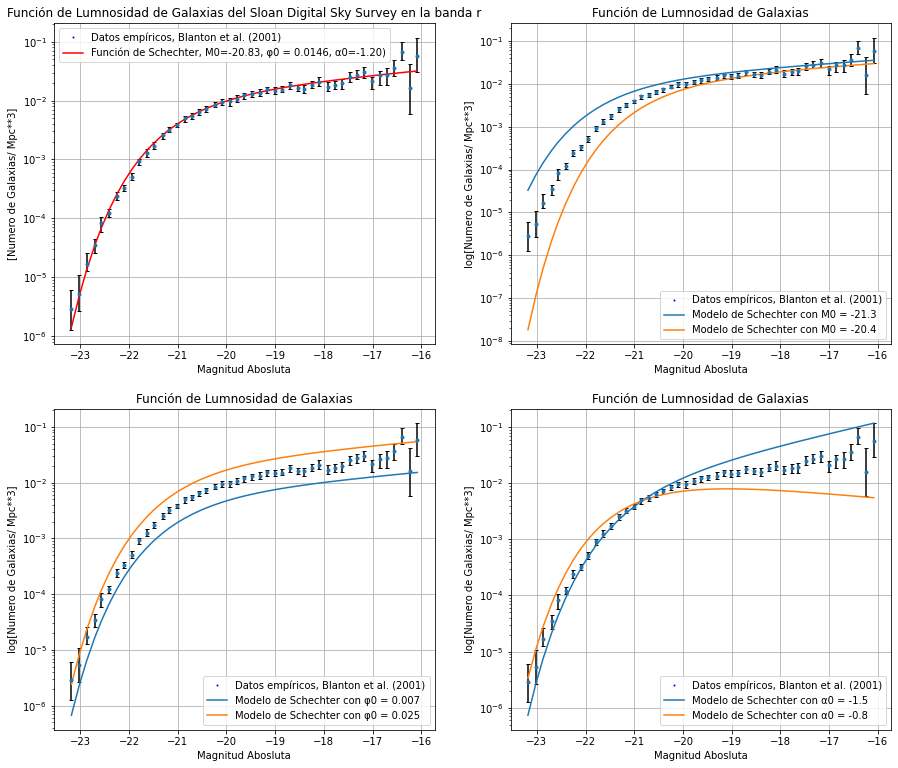

In [4]:
plt.figure(figsize=(15, 13))


plt.subplot(2,2,1)
f_error = [e_inf, e_sup]  
#plt.plot(M, e_inf,'.',label= 'error inferior')
#plt.plot(M, e_sup,'.',label= 'error superior')
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")

plt.xlabel('Magnitud Abosluta')
plt.ylabel('[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.semilogy()
plt.title('Función de Lumnosidad de Galaxias del Sloan Digital Sky Survey en la banda r')
y_teor =  phi_model(M)
plt.plot(M , y_teor  , color = 'r',label="Función de Schechter, M0=-20.83, φ0 = 0.0146, α0=-1.20)")
plt.legend()


plt.subplot(2,2,2)
param_low_M = (-21.3 , 1.46*10**(-2) , -1.20)   #vario el M (hacia valores mas chicos)
param_up_M = (-20.4, 1.46*10**(-2) , -1.20)   #vario el M (hacia valores mas grandes)
# veamos como afecta al modelo  variaciones en M
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")
y_lM = phi_model(M , param_low_M)  #lower M
plt.plot(M , y_lM  ,label="Modelo de Schechter con M0 = -21.3")
y_uM = phi_model(M , param_up_M)  #upper M
plt.plot(M , y_uM ,label="Modelo de Schechter con M0 = -20.4")
plt.xlabel('Magnitud Abosluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Función de Lumnosidad de Galaxias')
plt.semilogy()
plt.legend()


plt.subplot(2,2,3)
param_lowfi =  (-20.83 , 0.007, -1.20)   #vario el phi (hacia valores mas chicos)
param_upfi = (-20.83 , 0.025, -1.20)   #vario el phi (hacia valores mas grandes)
# veamos como afecta al modelo  variaciones en Phi
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")
y_lfi = phi_model(M , param_lowfi)
plt.plot(M , y_lfi  ,label="Modelo de Schechter con φ0 = 0.007")
y_ufi = phi_model(M , param_upfi)
plt.plot(M ,y_ufi ,label="Modelo de Schechter con φ0 = 0.025")
plt.xlabel('Magnitud Abosluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Función de Lumnosidad de Galaxias')
plt.semilogy()
plt.legend()


plt.subplot(2,2,4)
param_lowalph = (-20.83 , 1.46*10**(-2) , -1.5)   #vario el alpha (hacia valores mas chicos)
param_upalph = (-20.83 , 1.46*10**(-2) , -0.8)   #vario el alpha (hacia valores mas grandes)
# veamos como afecta al modelo  variaciones en alpha
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")
y_lalph = phi_model(M, param_lowalph)
plt.plot(M , y_lalph  ,label="Modelo de Schechter con α0 = -1.5")
y_ualph = phi_model(M, param_upalph)
plt.plot(M , y_ualph  ,label="Modelo de Schechter con α0 = -0.8")
plt.xlabel('Magnitud Abosluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Función de Lumnosidad de Galaxias')
plt.semilogy()
plt.legend()




La inferencia estadistica se puede llevar a cabo como una aplicacion del teorema de Bayes. Dado un conjunto de datos d que se puede describir mediante un modelo m con parametros $\phi$, se desea obtener el mejor ajuste. Es decir que el objetivo es maximizar la probabilidad posterior de los parametros $p(\phi | d,m)$, para un modelo parametrico m, dados los datos (que el modelo intenta describir).

Por otro lado, se tiene que esta probabilidad posterior es proporcional al Likelihood $p(d | \phi,m) = \prod_{j=1}^N \exp(-(\frac{Phi[j] - m(Mag[j],\phi)}{\sigma[j]})^2) $, al prior $ p(\phi,m)$ es decir aquello que ya se conoce de los parametros, y  esta normalizado por la evidencia  $p(d,m) $ la cual se toma en este caso igual a 1, i.e $p(d,m)=1$. Por lo tanto:
$$ Probabilidad\,\, Posterior:\,\,  p(\phi | d,m) = \frac{p(d | \phi,m)p(\phi,m)}{p(d,m)=1} = p(d | \phi,m)p(\phi,m)           $$

Se puede observar en la figura anterior que variando cada uno de los parametros y manteniendo al resto fijos, se puede definir un cierto intervalo para cada parametro, cuyos valores extremos estan dados por estas funciones limites que ya se desvian suficientemente de los datos como para decir que ya no producen un buen ajuste. Estos intervalos se tomaron de manera tal que las funciones limites que producen lleguen a contener las barras de error de los datos.

Se definen entonces los siguientes intervalos como los mas probables de contener los valores optimos de los parametros:

$ I_{M_0} = (-21.3 \,\, , \,\, -20.4)$

$ I_{\phi_0} = (0.007 \,\, , \,\, 0.025)$

$ I_{\alpha_0} = (-1.5 \,\, , \,\, -0.8)$

Dado que, a priori, no se tiene mas informacion que esta respecto de los valores que pueden llegar a tener los parametros, se utilizara un prior plano, definido como :

$$  prior:  p(\phi,m) = \left\{
    \begin{array}\\
        1 & \mbox{if } \ \phi \in R \\
        0 & \mbox{else.}
    \end{array}
\right. $$
Donde R es una ragion en el espacio 3D dada por: $ R = I_{M_0}\,$ x $\,I_{\phi_0}\,$x$\,I_{\alpha_0} $           
           
A continuacion, se definen las funciones relevantes: Likelihood, Prior y Probabilidad Posterior, al final se decidio trabajar con el logaritmo de dichas funciones por ser mas comodo y ademas porque no cambia el comportamiento (creciente o decreciente) de las mismas. Con lo cual, tenemos que 
 $$log(Likelihood) : \log(p(d | \phi,m)) = \sum_{j=1}^N -((\frac{Phi[j] - m(Mag[j],\phi)}{\sigma[j]})^2) $$

 $$  log(prior):  \log(p(\phi,m)) = \left\{
    \begin{array}\\
        0 & \mbox{if } \ \phi \in R \\
        -∞ & \mbox{else.}
    \end{array}
\right. $$

$$ \log(Probabilidad\,\,Posterior):\,\,log(p(\phi | d,m)) = \left\{
    \begin{array}\\
        \log(p(d | \phi,m)) & \mbox{if } \ \phi \in R \\
        ∞ & \mbox{else.}
    \end{array}
\right. $$

In [5]:
I_M = [-21.3, -20.4]
I_fi = [0.007 , 0.025]
I_a = [-1.5 , -0.8]

In [6]:
p0 = [-20.83 , 1.46*10**(-2) , -1.20]   #p0 = M_0, phi_0, alpha  parametros originales


# Se definen las funciones log(Likelihood), log(priors) , log(prob_posterior)


def log_L(data,model,param=p0): #defino el log de la funcion 'likelihood' (aprox) d son los datos (mag ,phi);  m es el modelo m=m(p);  p:parametros
    sigma = (e_inf + e_sup)*0.5
    suma = np.sum( ( ( data[1] - model(data[0],param) )**2/(2.0*sigma**2) ))
    return(suma)



def log_prior(p, M0 = I_M , phi = I_fi , a = I_a): # p = parámetros = (M , phi , alpha) 
    if ((M0[0] < p[0]) and (p[0] < M0[1]) and (phi[0] < p[1]) and (p[1] < phi[1]) and (a[0] < p[2]) and (p[2] < a[1])):
        y = 0
    else:
        y = -np.inf
    return(y)


# aca suponemos la evidencia = p(d,m) = 1 probabilidad marginal del Likelihood para el modelo m  
# (d: datos), m es el modelo, p parametros y f es el log_prior
def log_post(data , model , param):
    y = log_L(data,model,param) + log_prior(param)
    return(y)


#ahora quiero MINIMIZAR el (-)likelihood
datos = [M,f]

print('el valor minimo (aprox) de (-1)likelihood con los parametros originales es:',p0, log_post(datos, phi_model, p0))


el valor minimo (aprox) de (-1)likelihood con los parametros originales es: [-20.83, 0.0146, -1.2] 14.859291970919923


A continucion se implementa el algorimto de Metropolis-Hastings para explorar el espacio de parametros y en este caso se decide minimizar la funcion (-)likelihood en vez de maximizar el (+)likelihood.
Es decir se minimiza la funcion  $$-log(Likelihood) : -\log(p(d | \phi,m)) = \sum_{j=1}^N (\frac{Phi[j] - m(Mag[j],\phi)}{\sigma[j]})^2 $$


El algoritmo de Metropolis-Hastings es un metodo de Cadenas de Markov Monte Carlo (MCMC sigla en ingles), el cual consiste en explorar el espacio de parametros y tiene la caracteristica que el paso siguiente de la cadena depende del paso anterior. Esencialemente,consiste en los sigueintes pasos:

* Tomar un estado inicial $x_{0}$
* Establecer $t=0$
* Iterar cuantas veces queramos
    * Generar un estado candidato x' siguiendo $g(x'|x_{t})$
    * Calcular la probabilidad de aceptación $A(x',x_{t})=\min \left(1,{\frac {P(x')}{P(x_{t})}}{\frac {g(x_{t}|x')}{g(x'|x_{t})}}\right)$
    * Aceptar o rechazar:
        * Generar un número aleatorio uniforme $u\in [0,1]$
        * Si $u\leq A(x',x_{t})$, se acepta el nuevo estado y se toma $x_{t+1}=x'$
        * Si $u>A(x',x_{t})$, se rechaza el nuevo estado y se toma el viejo estado $x_{t+1}=x_{t}$
    * Incrementar $t=t+1$

In [7]:

# algoritmo de Metropolis-Hastings, voy a maximizar el likelihood osea Minimizar (-)*likelihood

def Metropolis_Hastings(data , model , N ,  M0 = -20.5 , phi0 = 0.008 , alpha0 = -0.9):    # data son los datos, m es el modelo, dsp estan los valores iniciales y N  es el largo de la cadena
 
    #defino el step/salto maximo que voy a dar para cada parámetro
    M_sigma = ( I_M[1] -  I_M[0] )/100.0
    fi_sigma = ( I_fi[1] -  I_fi[0] )/100.0
    a_sigma = ( I_a[1] -  I_a[0] )/100.0

    params = np.zeros((N, 3)) # matriz donde cada fila son los 3 parametros con (-)likelihoods cada vez mas chicas
    params[0][0] , params[0][1]  , params[0][2] = M0 , phi0 , alpha0  # defino los parametros iniciales
    Ls = np.zeros(N) # aca voy a poner los valores sucesivos del likelihood de cada iteracion 
    
    for i in range(0,N-1):
        # doy un salto en el espacio de parametros (3D), a partir de dar un salto aleatorio en cada parametro 
        params[i+1][0] = params[i][0] + ( np.random.rand()*2 - 1.0)*M_sigma
        params[i+1][1] = params[i][1] + ( np.random.rand()*2 - 1.0)*fi_sigma
        params[i+1][2] = params[i][2] + ( np.random.rand()*2 - 1.0)*a_sigma
        #print( ' vieja posterior' ,log_post(data , model , params[i]))

        Ls[i] = log_post(data , model , params[i] ) #guardo el valor viejo del likelihood
        # Ahora calculo el nuevo valor del likelihood y se lo resto al anterior, osea hago el cociente de probabilidades
        r =  log_post(data , model , params[i]) - log_post(data , model , params[i+1])
        #print(r)
        
        # si log( prob_post(i) ) > log( prob_post(i+1) ), acepto el salto y sigo
        if r > 100000:
    # En este caso redefino los parametros y me quedo con los valores anteriores, osea rechazo el salto
            #print('se fue de la ragion',r)
            params[i+1][0] = params[i][0]
            params[i+1][1] = params[i][1] 
            params[i+1][2] = params[i][2] 
        
        if ( r <= 0.0):  # Si no,todavia tengo una probabilidad = prob_ratio*100% de aceptar al paso de todas formas
            prob_ratio = np.exp(r)    # me saco el log de encima porq necesito que sea un numero entre 0 y 1
            random = np.random.rand()  #tiro un numero random entre 0 y 1
            
            if random >= prob_ratio: #rechazo el salto sólo si la prob_ratio es mas chica que el random 
            # En este caso redefino los parametros y me quedo con los valores anteriores, osea rechazo el salto
 
                params[i+1][0] = params[i][0] 
                params[i+1][1] = params[i][1] 
                params[i+1][2] = params[i][2] 
                #print('rechazo el nuevo likeli, me quedo con el valor anterior',log_post(data , model , params[i+1]) )             

    return(params,Ls)
 
       



Text(0.5, 1.0, 'Evolución del Likelihood')

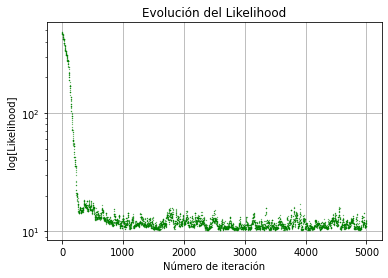

In [8]:
## CUIDADO!
param, Ls = Metropolis_Hastings(datos , phi_model , 5000)

plt.plot(Ls, '.' , ms = 0.5 , color = 'g')
plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')


In [9]:
_m = param[:,0]  # de la matriz me quedo con la primer columna que son los M
_phi = param[:,1]  # de la matriz me quedo con la segunda columna que son los  φ

_alpha = param[:,2]  # de la matriz me quedo con la tercer columna que son los α 

Text(0.5, 0, 'M')

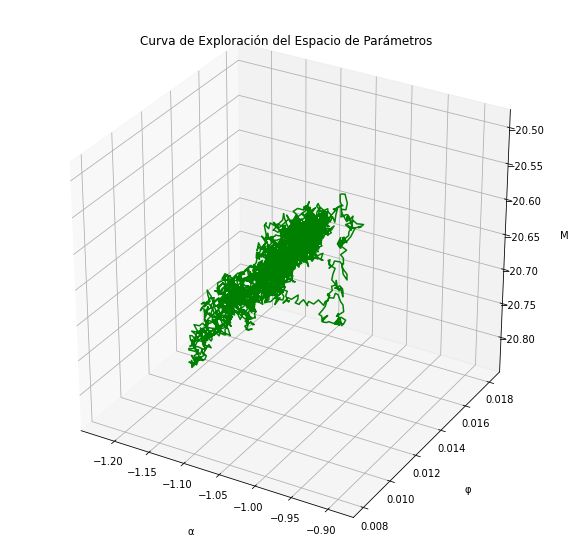

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ='3d')
ax.plot3D(  _alpha , _phi, _m , 'green')
ax.set_title('Curva de Exploración del Espacio de Parámetros')
ax.set_xlabel('α', labelpad=20)
ax.set_ylabel('φ', labelpad=20)
ax.set_zlabel('M', labelpad=20)


Se puede observar tanto en la figura de la evolucion del Likelihood como en la curva que se dibuja en el espacio de parametros,  que al principio los valores del (-)likelihood son muy grandes y lo mas probable es que el algoritmo de M-H tome aquellos saltos que lo lleven a valores menores. Sin embargo,luego de los 1000 primeros saltos empieza a acercarse al minimo, y alli, dado que tiene  la posibilidad de aceptar valores que lo desvien un poco del minimo, empieza a explorar un poco mas el espacio de parametros, oscilando alrededor de los valores optimos para los parametros que generan el mejor ajuste a los datos. 

Text(0.5, 1.0, 'Corte en el Espacio de Parámetros, M = cte')

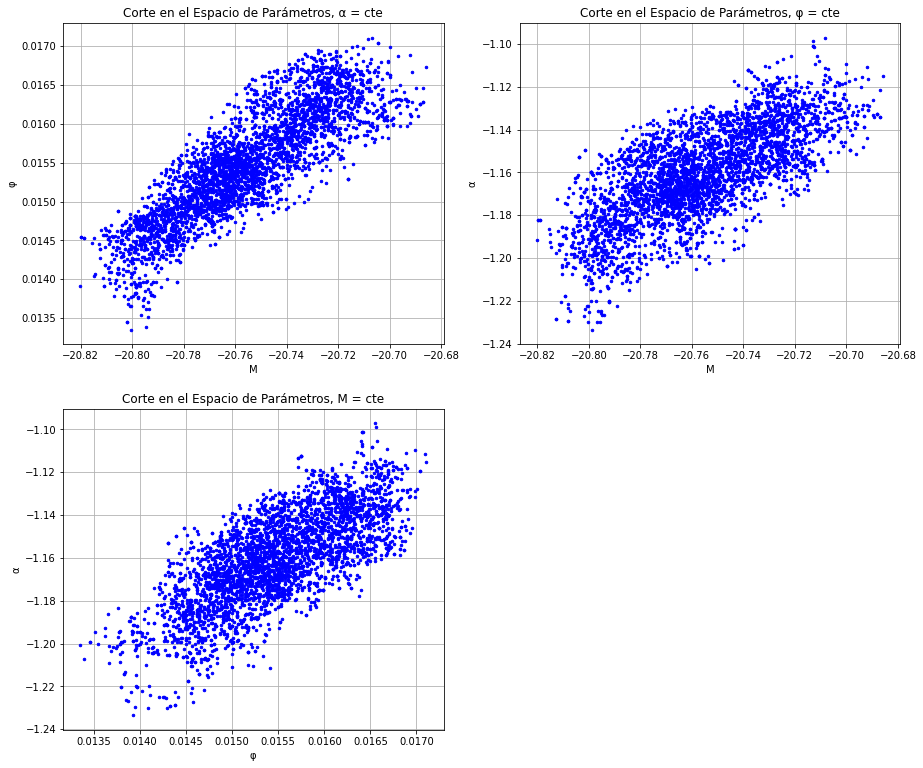

In [10]:
plt.figure(figsize=( 15 , 13))

plt.subplot(2,2,1)
plt.plot(_m[1000:],_phi[1000:],'.', ms = 5 , color = 'b')
plt.xlabel('M')
plt.ylabel('φ')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, α = cte')

plt.subplot(2,2,2)
plt.plot(_m[1000:],_alpha[1000:],'.',ms = 5, color = 'b')
plt.xlabel('M')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, φ = cte')

plt.subplot(2,2,3)
plt.plot(_phi[1000:],_alpha[1000:],'.',ms = 5 , color = 'b')
plt.xlabel('φ')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, M = cte')





# Mal mezclado

A continuacion vemos que sucede si no se explora todo el espacio de parametros. Se generan multiples cadenas de manera que todas empiecen de condiciones inciales similares, es decir de una dada region del espacio de parametros, algo conocido tambien como 'mal mezclado' de las cadenas. 

In [11]:

N_steps = 5000   #numeros maximo de pasos en una cadena
n_chains = 10     # numero de cadenas de Markov

I_M1 = [-21.3, -20.9]
I_fi1 = [0.007 , 0.016]
I_a1 = [-1.5 , -1.1]

eps = 0.001  # no quiero que me elija los extremos del intervalo porque el prior va a dar -inf
M_values1 = np.linspace(I_M1[0] + eps , I_M1[1] - eps , 50)   
fi_values1 = np.linspace(I_fi1[0] + eps , I_fi1[1] - eps , 50)
a_values1 = np.linspace(I_a1[0] + eps , I_a1[1] - eps , 50)

np.random.seed(10)
m_init1 = np.random.choice(M_values1 , n_chains , replace=False)
#print(m_init)
f_init1 = np.random.choice(fi_values1 , n_chains, replace=False )
#print(f_init)
a_init1 = np.random.choice(a_values1 , n_chains, replace=False)
#print(a_init)

In [12]:
# CUIDADO!!

par_1 = np.zeros((n_chains,N_steps,3))
Likeli_1 = np.zeros((n_chains, N_steps))

for i in range(0,n_chains):
    #print( m_init[i], f_init[i] , a_init[i])
    par_1[i,:,:] , Likeli_1[i,:] = Metropolis_Hastings(datos , phi_model , N_steps , m_init1[i], f_init1[i] , a_init1[i])

Text(0.5, 1.0, 'Evolución del Likelihood')

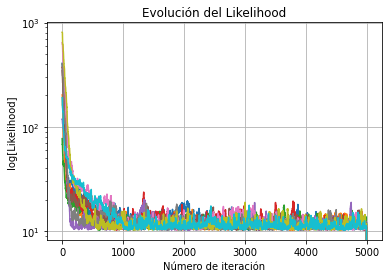

In [13]:
for i in range(0,n_chains):
   plt.plot(Likeli_1[i,:])

plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')

Text(0.5, 1.0, 'Likelihood vs parametro α')

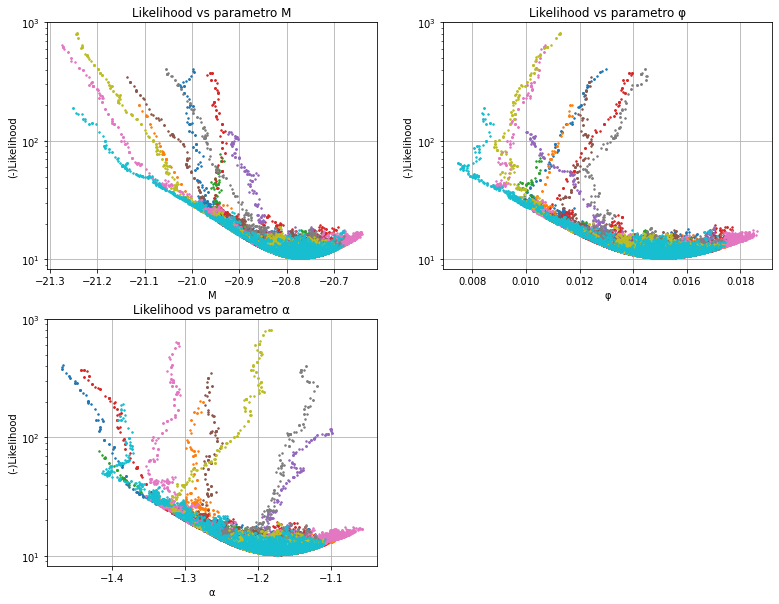

In [15]:
plt.figure(figsize = (13,10))

# Grafico del Likelihood vs M
plt.subplot(2,2,1)
for i in range(n_chains):
  plt.plot(par_1[i,:,0],Likeli_1[i,:],'.',ms = 3)

plt.xlabel('M')
plt.ylabel('(-)Likelihood')
plt.semilogy()
plt.grid()
plt.title('Likelihood vs parametro M')


# Grafico del Likelihood vs PHI
plt.subplot(2,2,2)
for i in range(n_chains):
  plt.plot(par_1[i,:,1],Likeli_1[i,:],'.',ms = 3)

plt.xlabel('φ')
plt.ylabel('(-)Likelihood')
plt.semilogy()
plt.grid()
plt.title('Likelihood vs parametro φ')


# Grafico del Likelihood vs ALPHA
plt.subplot(2,2,3)
for i in range(n_chains):
  plt.plot(par_1[i,:,2],Likeli_1[i,:],'.',ms = 3)

plt.xlabel('α')
plt.ylabel('(-)Likelihood')
plt.semilogy()
plt.grid()
plt.title('Likelihood vs parametro α')

De las ultimas figuras, se puede observar que las cadenas con 'mal mezclado' parten desde una misma region, por ejemplo cuando se grafica el (-)likelihood  vs algun parametro,todas provienen de una misma direccion (desde el lado izquierdo) con lo cual hay cierta region de posibles parametros que no se explora. No obstante, en este caso no afecta la convergencia de las cadenas ya que solo existe un minimo, pero en otros casos donde podria haber mas de un minimo local, un mal mezlcado podria producir que las cadenas se queden atrapadas en un minimo que no es el buscado. De esta forma, si no se explora bien el espacio de parametros este 'minimo falso' pasaria inadvertido y los parametros hallados no serian los optimos para ajustar el modelo a los datos.



# Buen mezclado 

A continuacion, se genera un conjunto de cadenas con un buen mezlcado, es decir que aleatoriamente se elijen valores iniciales en todo el rango posible de parametros.

In [18]:
N_steps = 5000   #numeros maximo de pasos en una cadena
n_chains = 10     # numero de cadenas de Markov

I_M = [-21.3, -20.4]
I_fi = [0.007 , 0.025]
I_a = [-1.5 , -0.8]

eps = 0.001  # no quiero que me elija los extremos del intervalo porque el prior va a dar -inf
M_values = np.linspace(I_M[0] + eps , I_M[1] - eps , 50)   
fi_values = np.linspace(I_fi[0] + eps , I_fi[1] - eps , 50)
a_values = np.linspace(I_a[0] + eps , I_a[1] - eps , 50)


m_init = np.random.choice(M_values , n_chains , replace=False)
#print(m_init)
f_init = np.random.choice(fi_values , n_chains, replace=False )
#print(f_init)
a_init = np.random.choice(a_values , n_chains, replace=False)
#print(a_init)


In [19]:
### CUIDADO

par = np.zeros((n_chains,N_steps,3))
Likeli = np.zeros((n_chains, N_steps))

for i in range(0,n_chains):
    #print( m_init[i], f_init[i] , a_init[i])
    par[i,:,:] , Likeli[i,:] = Metropolis_Hastings(datos , phi_model , N_steps , m_init[i], f_init[i] , a_init[i])

    
### CUIDADO
    

Text(0.5, 1.0, 'Corte en el Espacio de Parámetros, M = cte')

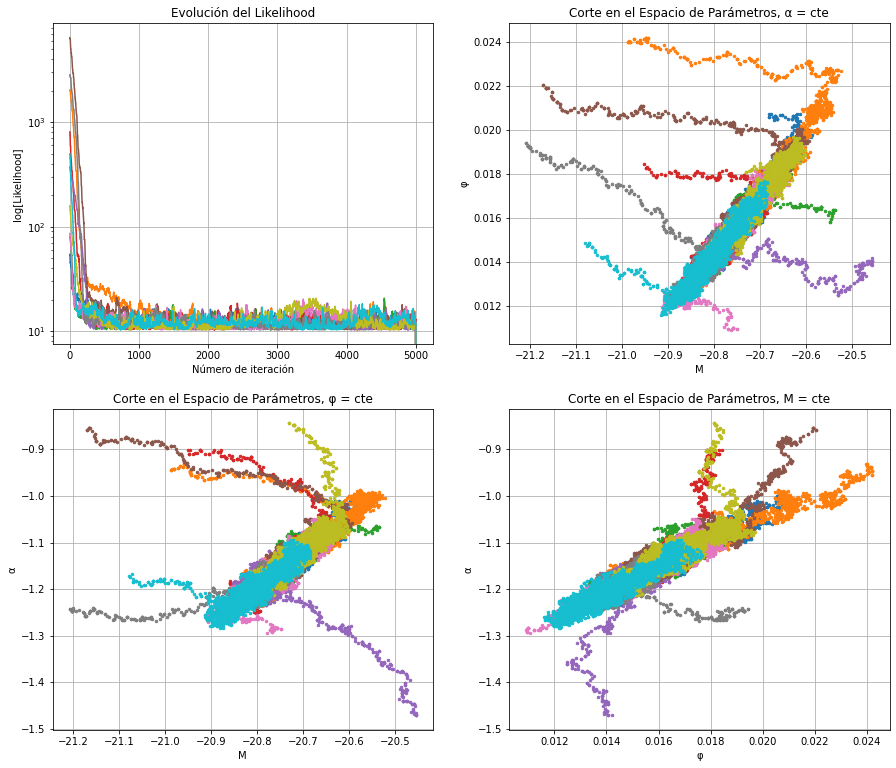

In [20]:
plt.figure(figsize = (15,13))

plt.subplot(2,2,1)
for i in range(0,n_chains):
   plt.plot(Likeli[i,:])

plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')


plt.subplot(2,2,2)
for i in range(n_chains):
  plt.plot(par[i,:,0],par[i,:,1],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('φ')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, α = cte')


plt.subplot(2,2,3)
for i in range(n_chains):
  plt.plot(par[i,:,0],par[i,:,2],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, φ = cte')


plt.subplot(2,2,4)
for i in range(n_chains):
  plt.plot(par[i,:,1],par[i,:,2],'.',ms = 5)

plt.xlabel('φ')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, M = cte')

Text(0.5, 1.0, 'Likelihood vs parametro α')

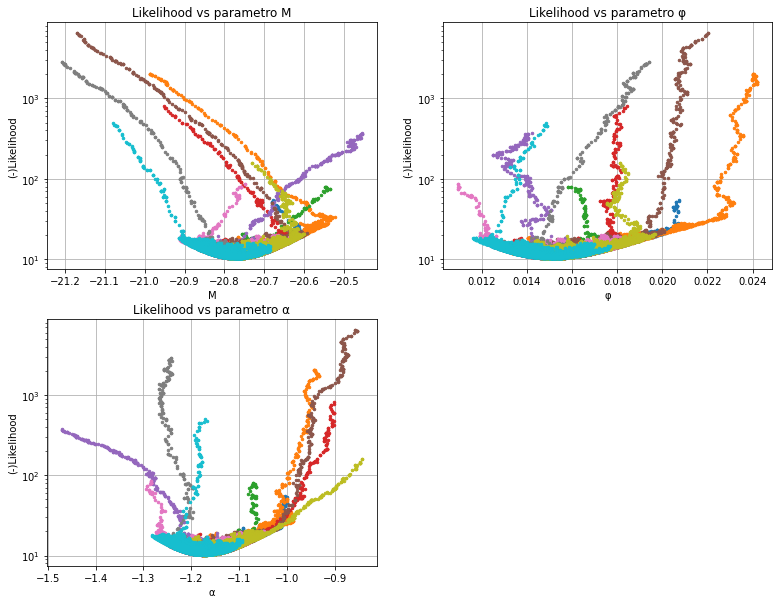

In [21]:
plt.figure(figsize = (13,10))

# Grafico del Likelihood vs M
plt.subplot(2,2,1)
for i in range(n_chains):
  plt.plot(par[i,:,0],Likeli[i,:],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('(-)Likelihood')
plt.semilogy()
plt.grid()
plt.title('Likelihood vs parametro M')


# Grafico del Likelihood vs PHI
plt.subplot(2,2,2)
for i in range(n_chains):
  plt.plot(par[i,:,1],Likeli[i,:],'.',ms = 5)

plt.xlabel('φ')
plt.ylabel('(-)Likelihood')
plt.semilogy()
plt.grid()
plt.title('Likelihood vs parametro φ')


# Grafico del Likelihood vs ALPHA
plt.subplot(2,2,3)
for i in range(n_chains):
  plt.plot(par[i,:,2],Likeli[i,:],'.',ms = 5)

plt.xlabel('α')
plt.ylabel('(-)Likelihood')
plt.semilogy()
plt.grid()
plt.title('Likelihood vs parametro α')



Text(0.5, 1.0, 'Parametro α vs Eslabon de la cadena')

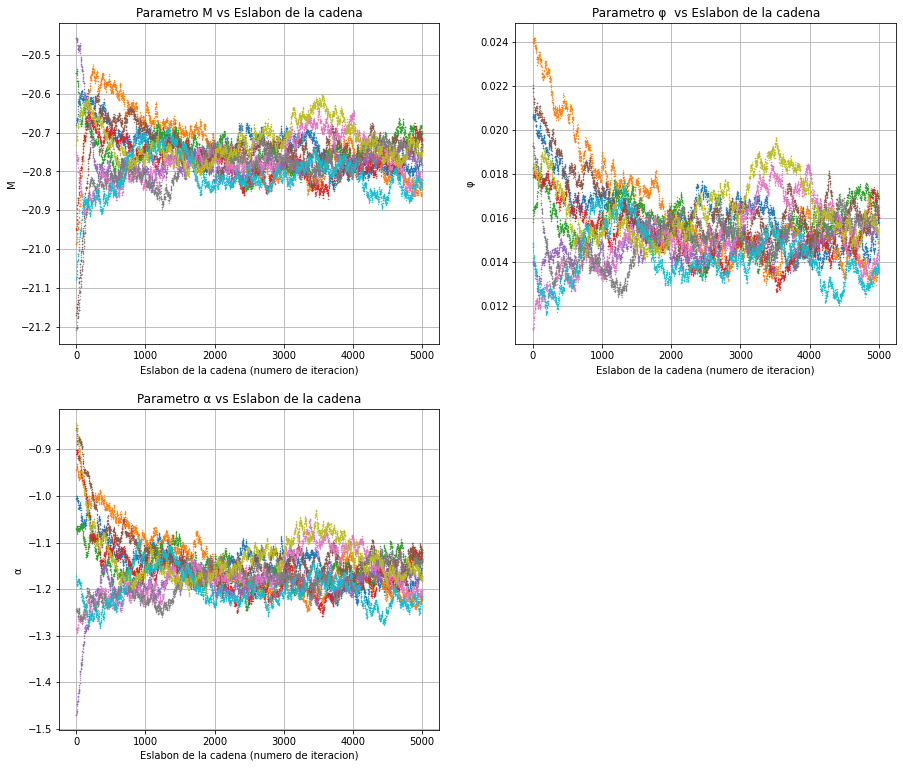

In [22]:
plt.figure(figsize = (15,13))

eslabones = np.arange(0,N_steps,1)
#print(eslabones.shape)
cadenas = np.zeros((n_chains,N_steps))
#print(cadenas)


# Grafico del parametro M vs eslabon de la cadena
plt.subplot(2,2,1)
for i in range(n_chains):
    cadenas[i,:] = eslabones
    plt.plot(cadenas[i,:], par[i,:,0],'.',ms = 0.7)
    
plt.xlabel('Eslabon de la cadena (numero de iteracion)')
plt.ylabel('M')
#plt.semilogx()
plt.grid()
plt.title('Parametro M vs Eslabon de la cadena')

# Grafico del parametro PHI vs eslabon de la cadena
plt.subplot(2,2,2)
for i in range(n_chains):
    cadenas[i,:] = eslabones
    plt.plot(cadenas[i,:], par[i,:,1],'.',ms = 0.7)
    
plt.xlabel('Eslabon de la cadena (numero de iteracion)')
plt.ylabel('φ')
#plt.semilogx()
plt.grid()
plt.title('Parametro φ  vs Eslabon de la cadena')



# Grafico del parametro ALPHA vs eslabon de la cadena
plt.subplot(2,2,3)
for i in range(n_chains):
    cadenas[i,:] = eslabones
    plt.plot(cadenas[i,:], par[i,:,2],'.',ms = 0.7)
    
plt.xlabel('Eslabon de la cadena (numero de iteracion)')
plt.ylabel('α ')
#plt.semilogx()
plt.grid()
plt.title('Parametro α vs Eslabon de la cadena')

Los graficos son coherentes entre si y muestran que efectivamente todas las cadenas converegen hacia ciertos valores para los parametros que tambien estan cerca de los valores obtenidos de la bibliografia.

Ahora se busca obtener analiticamente el valor medio de los parametros que generan el mejor ajuste a los datos. Para esto, se tomara un promedio para cada parametro de todos los valores obtenidos en todas las cadenas, despues de los 1000 primeros pasos, es decir una vez que ya se produjo el 'quemado' de la cadena. 

Text(0.5, 1.0, 'Distribucion del Parametro M_0')

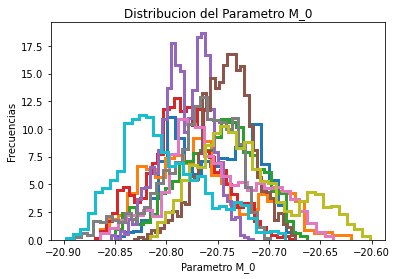

In [23]:
# Disribucion de valores obtenidos con MCMC del parametro M0

for i in range(n_chains):  
    
    plt.hist(par[i,1000:,0], bins= 'auto' , density = True, histtype = 'step', lw = 3)
    
plt.xlabel('Parametro M_0')
plt.ylabel('Frecuencias')
plt.title('Distribucion del Parametro M_0')    



Text(0.5, 1.0, 'Distribucion del Parametro φ_0')

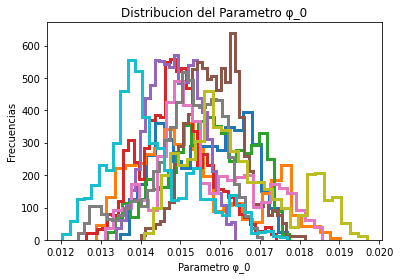

In [24]:
# Disribucion de valores obtenidos con MCMC del parametro φ_0

for i in range(n_chains):  
    
    plt.hist(par[i,1000:,1], bins= 'auto' , density = True, histtype = 'step', lw = 3)
    
plt.xlabel('Parametro φ_0')
plt.ylabel('Frecuencias')
plt.title('Distribucion del Parametro φ_0')  

Text(0.5, 1.0, 'Distribucion del Parametro α _0')

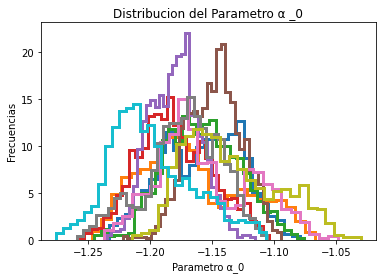

In [25]:
# Disribucion de valores obtenidos con MCMC del parametro α_0
for i in range(n_chains):  
    
    plt.hist(par[i,1000:,2], bins= 'auto' , density = True, histtype = 'step', lw = 3)
    
plt.xlabel('Parametro α_0')
plt.ylabel('Frecuencias')
plt.title('Distribucion del Parametro α _0')  

Se observa que para cada cadena (despues de la etapa de quemado) se genera una distribucion aproximadamente gaussiana para los parametros, cuyo valor medio seria el que tiene maxima probabilidad posterior de ajustarse bien a los datos, dado el modelo.

In [27]:
# quiero obtener la media
par.shape
M_list = []
phi_list = []
alpha_list = []

# Obtengo el valor medio de M, phi y alpha para cada cadena de markov (10 medias para cada parametro)
for i in range(n_chains):
    M_list.append(par[i,1000:,0])
    phi_list.append(par[i,1000:,1] )
    alpha_list.append(par[i,1000:,2])


#print(M_list, phi_list , alpha_list)

# Calculo el M promedio
M_mean = np.mean(M_list)
M_error = np.std(M_list)
print(M_mean,M_error )

# Calculo el PHI promedio
phi_mean = np.mean(phi_list)
phi_error = np.std(phi_list)
print(phi_mean,phi_error )

# Calculo el ALPHA promedio
alpha_mean = np.mean(alpha_list)
alpha_error = np.std(alpha_list)
print(alpha_mean,alpha_error )


-20.762374125239532 0.04499980231531405
0.01537004118497427 0.0011911729472512053
-1.1656047718672116 0.03658643387940981


Por lo tanto, a partir del algoritmo de Metropolis Hastings se han obtenido los valores optimos de los parametros. Estos valores son aquellos con los que el modelo de Schechter mejor describe los datos:

$$ M_0 = -20.77 \pm 0.04  $$

$$ \phi_0 = (1.5 \pm 0.1) *10^{-2} $$

$$ \alpha_0 = -1.17 \pm 0.03  $$

En esta instancia, se realizara nuevamente la busqueda de los mejores parametros pero a traves del metodo del gradiente descendente. Este metodo, consiste en trazar una curva en el espacio de parametros cuya trayectoria es determinada por los valores iniciales de estos y siguiendo la direccion del (-)gradiente en cada punto. Es decir que ahora no se explora el espacio de parametros, sino que cada salto esta dirigido en la direccion de $ - ∇(-p(d| \phi,m)) $, o sea se quiere minimizar ($- ∇$ ), el  (-)likelihood ( $ -p(d| \phi,m)$ ).

In [29]:
# defino el gradiente del (-)likelihood
M = tabla['MAG']
f = tabla['PHI']

def grad_likeli(par,x = M, y = f ,model = phi_model ):   # parametros = m , phi , alpha
    sigma = (e_inf + e_sup)*0.5

    m1 = model(x,par)   # par[0] = M0 , par[1] = Phi0 , par[2] = Alpha0
    g = -0.4*(x - par[0])
    factor = ( -1 / sigma**2 )*(f - m1)
    #print(f)
    
    z = np.zeros(3)
    z[0] = np.sum( factor*m1*np.log(10)*0.4*( par[2] + 1 - 10**g ) )
    b = m1*np.log(10)*0.4*( par[2] + 1 - 10**g)
    #print(b)
    z[1] = np.sum( factor*m1/par[1]  )
    z[2] = np.sum(  factor*m1*np.log(10)*g)
    
    return(z)

#v =[-20.83 , 0.0146 , -1.2]
#grad_likeli(v)

In [30]:
I_M = [-21.3, -20.4]
I_fi = [0.007 , 0.025]
I_a = [-1.5 , -0.8]

M_sigma = ( I_M[1] -  I_M[0] )/50
fi_sigma = ( I_fi[1] -  I_fi[0] )/50.0
a_sigma = ( I_a[1] -  I_a[0] )/50.0

print(M_sigma, fi_sigma , a_sigma) 

0.018000000000000044 0.00036 0.013999999999999999


In [31]:

def Gradiente_Descendente(N ,  M0 = -20.5 , phi0 = 0.008 , alpha0 = -0.9):    # data son los datos, m es el modelo, dsp estan los valores iniciales y N  es el largo de la cadena
 
    #defino el step/salto maximo que voy a dar para cada parámetro
    params = np.zeros((N, 3)) # matriz donde cada fila son los 3 parametros con (-)likelihoods cada vez mas chicas
    params[0][0] , params[0][1]  , params[0][2] = M0 , phi0 , alpha0  # defino los parametros iniciales
    Ls = np.zeros(N) # aca voy a poner los valores sucesivos del likelihood de cada iteracion 
    
    for i in range(0,N-1):
        step = grad_likeli(params[i])
        #print(step)
        norm = ( step[0]**2 + step[1]**2 + step[2]**2 )**(0.5)
        #print('norma',norm)
        
        params[i+1][0] = params[i][0] - (M_sigma*step[0])/norm
        params[i+1][1] = params[i][1] - (fi_sigma*step[1])/norm
        params[i+1][2] = params[i][2] - (a_sigma*step[2])/norm

        #print( 'step',(M_sigma*step[0])/norm, (fi_sigma*step[1])/norm , (a_sigma*step[2])/norm )

        Ls[i] = log_post([M , f], phi_model , params[i]) 
        #print(Ls[i])   
    return(params,Ls)

In [33]:
N_final = 1500

parameters , L_grad = Gradiente_Descendente(N_final)
#print(L_grad)

print('Estos son los parametros finales, M_0 , phi_0, alpha_0', parameters[N_final-1,0], parameters[N_final-1,1], parameters[N_final-1,2])

Estos son los parametros finales, M_0 , phi_0, alpha_0 -20.770349829358594 0.014845973737844912 -1.1727045738752697


Text(0.5, 1.0, 'Corte en el Espacio de Parámetros, M = cte')

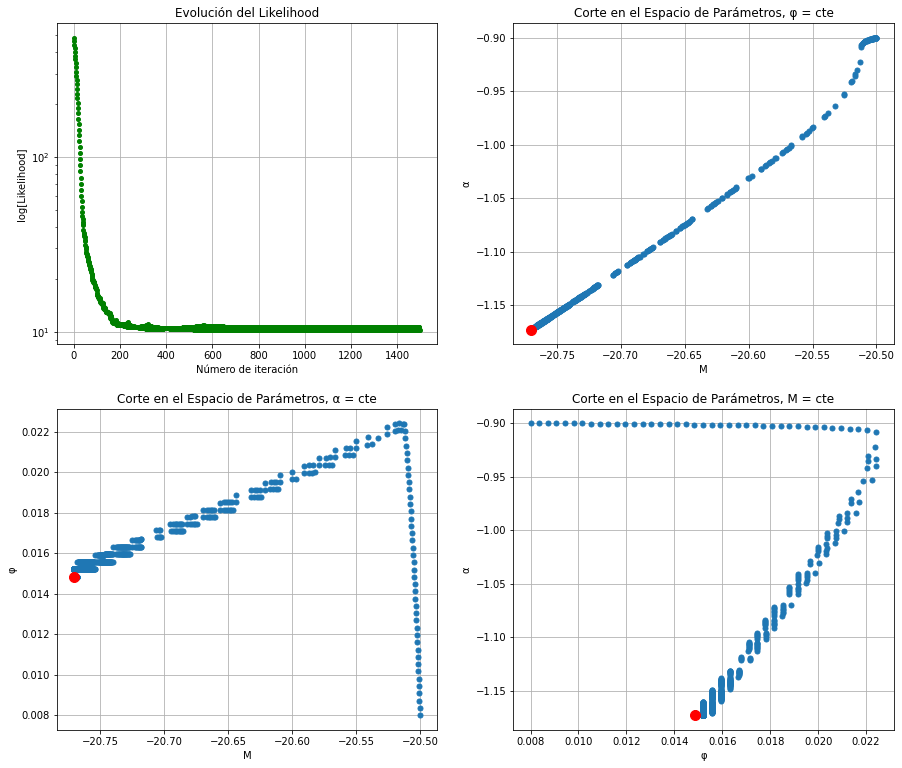

In [34]:


plt.figure(figsize = (15,13))

plt.subplot(2,2,1)
plt.plot(L_grad, '.' , ms = 8 , color = 'g')
plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')

plt.subplot(2,2,2)
plt.plot(parameters[:,0],parameters[:,2],'.',ms = 10)
plt.plot(parameters[N_final-1,0],parameters[N_final-1,2], '.' ,ms = 20,color = 'r')
plt.xlabel('M')
plt.ylabel('α')

plt.grid()
plt.title('Corte en el Espacio de Parámetros, φ = cte')


plt.subplot(2,2,3)
plt.plot(parameters[:,0],parameters[:,1],'.',ms = 10)
plt.plot(parameters[N_final-1,0],parameters[N_final-1,1], '.' ,ms = 20,color = 'r')
plt.xlabel('M')

plt.ylabel('φ')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, α = cte')


plt.subplot(2,2,4)
plt.plot(parameters[:,1],parameters[:,2],'.',ms = 10)
plt.plot(parameters[N_final-1,1],parameters[N_final-1,2], '.' ,ms = 20,color = 'r')
plt.xlabel('φ')
plt.ylabel('α')
#plt.semilogy()
plt.grid()
plt.title('Corte en el Espacio de Parámetros, M = cte')



Text(0.5, 0, 'α')

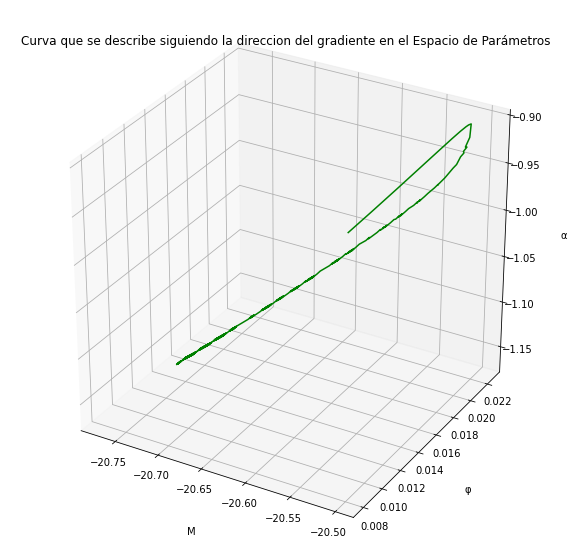

In [35]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ='3d')
ax.plot3D(  parameters[:,0] ,parameters[:,1], parameters[:,2] , 'green')
ax.set_title('Curva que se describe siguiendo la direccion del gradiente en el Espacio de Parámetros')
ax.set_xlabel('M', labelpad=20)
ax.set_ylabel('φ', labelpad=20)
ax.set_zlabel('α', labelpad=20)

En este caso, a diferencia de lo obtenido en M-H, se puede observar una curva directa que parte de los valores iniciales y se estabiliza alrededor de los parametros que minimizan el (-)likelihood. Otra diferencia clara es que demora mucho menos en converger, con 300 iteraciones ya practicamente se estabilizan los valores de los parametros.




A continuacion, se corren varios caminos de gradiente descendiente, a partir de distintos valores iniciales aleatoriamente escogidos. Luego se calcula el valor medio de los parametros optimos obtenidos con este metodo.

In [36]:
N_steps = 1500  #numeros maximo de pasos en una cadena
n_paths = 10     # numero de realizaciones (caminos) del metodo del gradiente descendente

I_M = [-21.3, -20.4]
I_fi = [0.007 , 0.025]
I_a = [-1.5 , -0.8]

eps = 0.001  # no quiero que me elija los extremos del intervalo porque el prior va a dar -inf
M_values = np.linspace(I_M[0] + eps , I_M[1] - eps , 50)   
fi_values = np.linspace(I_fi[0] + eps , I_fi[1] - eps , 50)
a_values = np.linspace(I_a[0] + eps , I_a[1] - eps , 50)

#np.random.seed()
m_init = np.random.choice(M_values , n_paths , replace=False)
#print(m_init)
f_init = np.random.choice(fi_values , n_paths, replace=False )
#print(f_init)
a_init = np.random.choice(a_values , n_paths, replace=False)
#print(a_init)


In [37]:
### CUIDADO

pars = np.zeros((n_paths,N_steps,3))
Likelis = np.zeros((n_paths, N_steps))

for i in range(0,n_paths):
    #print( m_init[i], f_init[i] , a_init[i])
    pars[i,:,:] , Likelis[i,:] = Gradiente_Descendente(N_steps , m_init[i] , f_init[i] , a_init[i])
    
### CUIDADO
    

Text(0.5, 1.0, 'Corte en el Espacio de Parámetros, M = cte')

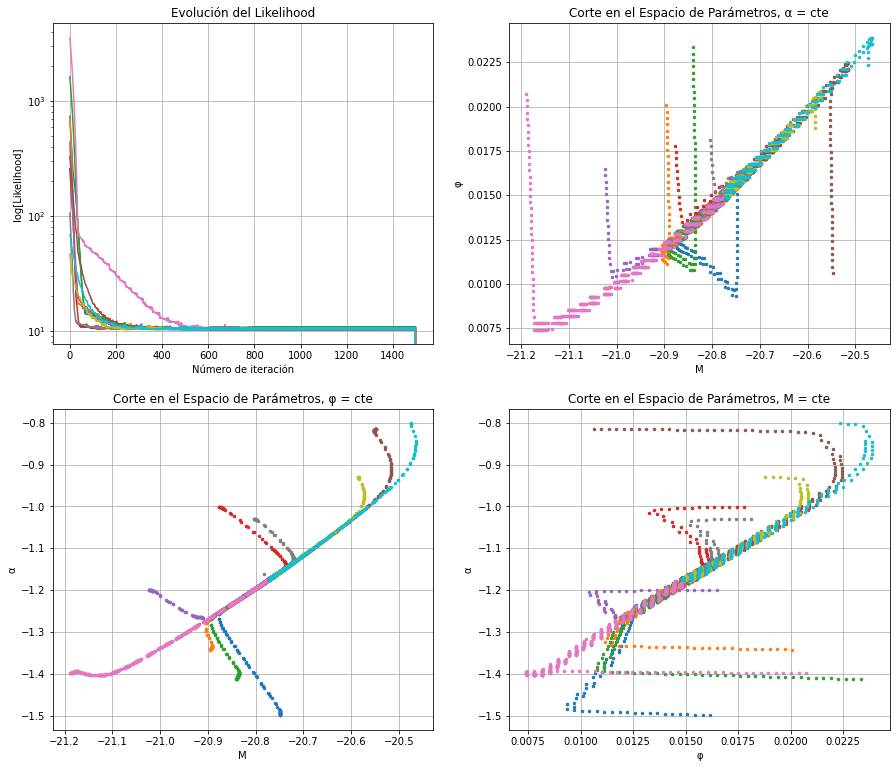

In [64]:
plt.figure(figsize = (15,13))

plt.subplot(2,2,1)
for i in range(0,n_paths):
   plt.plot(Likelis[i,:])

plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')


plt.subplot(2,2,2)
for i in range(n_paths):
  plt.plot(pars[i,:,0],pars[i,:,1],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('φ')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, α = cte')


plt.subplot(2,2,3)
for i in range(n_paths):
  plt.plot(pars[i,:,0],pars[i,:,2],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, φ = cte')


plt.subplot(2,2,4)
for i in range(n_paths):
  plt.plot(pars[i,:,1],pars[i,:,2],'.',ms = 5)

plt.xlabel('φ')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, M = cte')

In [66]:
# quiero obtener la media

# quiero obtener la media
pars.shape
M_list1 = []
phi_list1 = []
alpha_list1 = []

# Obtengo el valor medio de M, phi y alpha para cada cadena de markov (10 medias para cada parametro)
for i in range(n_paths):
    M_list1.append(pars[i,600:,0])
    phi_list1.append(pars[i,600:,1] )
    alpha_list1.append(pars[i,600:,2])

#print(parameters[1000:,2])
#print('todo',parameters[:,2])



# Calculo el M promedio
M_mean_grad = np.mean(M_list1)
M_error_grad = np.std(M_list1)
print(M_mean_grad,M_error_grad )

# Calculo el PHI promedio
phi_mean_grad = np.mean(phi_list1)
phi_error_grad = np.std(phi_list1)
print(phi_mean_grad,phi_error_grad )

# Calculo el ALPHA promedio
alpha_mean_grad = np.mean(alpha_list1)
alpha_error_grad = np.std(alpha_list1)
print(alpha_mean_grad,alpha_error_grad )

-20.77101501430986 0.002015830609959648
0.015061703174024254 0.00020329252757945115
-1.1731541528415934 0.0015597887368462265


A partir de realizar un promedio para cada parametro de todos los valores obtenidos en todos los caminos, despues de los 600 primeros pasos, se obtienen los siguientes resultados: 

$$ M_0 = -20.771 \pm 0.002  $$

$$ \phi_0 = (1.51 \pm 0.02) *10^{-2} $$

$$ \alpha_0 = -1.173 \pm 0.002  $$
Se observa que los mismos concuerdan con los encontrados por M-H y al ser este metodo mas eficiente en cuanto a computo para obtenerlos, es el mas conveniente de usar. No obstante, en otro caso donde el likelihood no tenga un solo minimo, lo mas prudente seria usar M-H y explorar adecuadamente el espacio de parametros.

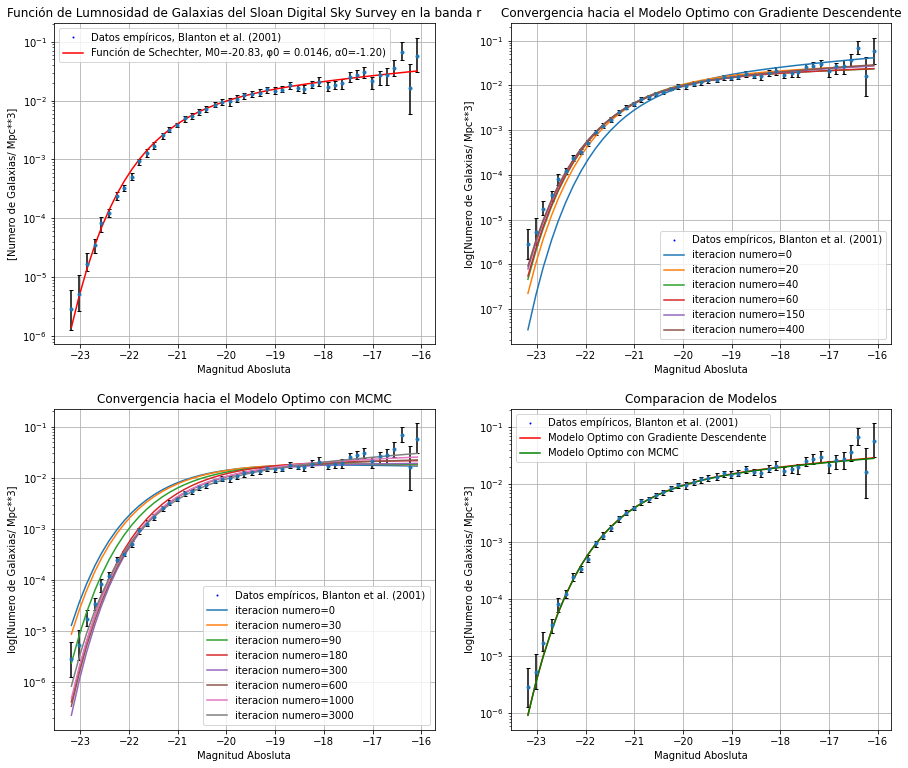

In [41]:
plt.figure(figsize=(15, 13))


plt.subplot(2,2,1)
f_error = [e_inf, e_sup]  
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")
plt.xlabel('Magnitud Abosluta')
plt.ylabel('[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.semilogy()
plt.title('Función de Lumnosidad de Galaxias del Sloan Digital Sky Survey en la banda r')
y_teor =  phi_model(M)
plt.plot(M , y_teor  , color = 'r',label="Función de Schechter, M0=-20.83, φ0 = 0.0146, α0=-1.20)")
plt.legend()


plt.subplot(2,2,2)
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")

for i in (0,20,40,60,150,400):
    y_grad = phi_model(M , pars[2,i,:])
    plt.plot(M , y_grad, label = 'iteracion numero='+str(i)+'' )

plt.xlabel('Magnitud Abosluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Convergencia hacia el Modelo Optimo con Gradiente Descendente')
plt.semilogy()
plt.legend()




plt.subplot(2,2,3)
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")

for i in (0,30,90,180,300,600,1000,3000):
    y_MCMC = phi_model(M , par[1,i,:])
    plt.plot(M , y_MCMC , label = 'iteracion numero='+str(i)+'')

plt.xlabel('Magnitud Abosluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Convergencia hacia el Modelo Optimo con MCMC')
plt.semilogy()
plt.legend()




plt.subplot(2,2,4)
#Datos empirircos
plt.plot(M , f , '.' , ms = 2 , color = 'b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M,f, yerr = f_error, fmt=".", capsize=2, ecolor="k")
#modelo obtenido con parametros medios que dio el algoritmo de Grad Descen
par_optim_grad = (-20.771 , 0.0151 , -1.173)
y_optim_grad = phi_model(M ,par_optim_grad )
plt.plot(M , y_optim_grad , label = 'Modelo Optimo con Gradiente Descendente', color = 'r')

#modelo obtenido con parametros medios que dio el algoritmo de Metrop Hast
par_optim_MCMC = (-20.77 , 0.015 , -1.17)
y__optim_MCMC = phi_model(M , par_optim_MCMC )
plt.plot(M , y__optim_MCMC ,label = 'Modelo Optimo con MCMC', color = 'g')

plt.xlabel('Magnitud Abosluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Comparacion de Modelos')
plt.semilogy()
plt.legend()


####  CONCLUSIONES

En este trabajo se han encontrado a traves de dos metodos distintos los valores de los parametros que producen el mejor ajuste a los datos del numero de galaxias por Mpc^3 en funcion de la magnitud, utilizando como modelo la funcion de Schechter. Se observa de la ultima figura que los valores que predice para los parametros el metodo de Metropolis-Hastings concuerdan con el de Gradiente Descendente, y a su vez concuerdan dentro del margen de error con los obtenidos por Blanton et al. (2001).

Metropolis-Hastings :
$$ M_0 = -20.77 \pm 0.04  $$

$$ \phi_0 = (1.5 \pm 0.1) *10^{-2} $$

$$ \alpha_0 = -1.17 \pm 0.03  $$


Gradiente Descendente:
$$ M_0 = -20.771 \pm 0.002  $$

$$ \phi_0 = (1.51 \pm 0.02) *10^{-2} $$

$$ \alpha_0 = -1.173 \pm 0.002  $$

Blanton:
$$ M_0 = -20.83 \pm 0.03  $$

$$ \phi_0 = (1.46 \pm 0.12) *10^{-2} $$

$$ \alpha_0 = -1.20 \pm 0.03  $$

Por ultimo, se destaca que el metodo del gradiente es el mas eficiente de usar en este caso ya que converge rapidamente (en la iteracion 40 de la figura) y la funcion del likelihood tiene un solo minimo. No obstante, puede que este metodo parezca tener una presicion mayor que no es tal, ya que el error tan chico que se obtiene es mas bien producto del hecho que no se exploro el espacio de parametros en profundidad. Por lo tanto, el metodo de Metropolis-Hastings, si bien es mas costoso computacionalmente , es el mas prudente de utilizar para explorar adecuadamente los posibles valores de los parametros que pueden ajustar el modelo a los datos; siempre y cuando se tenga el cuidado tambien de que se produzca un buen mezclado de las cadenas. 


